In [34]:
  # import libraries
import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt

# Create Gaussian blurs with varying widths and occluding bars

In [35]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
images = torch.zeros(nGauss,1,imgSize,imgSize)

for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

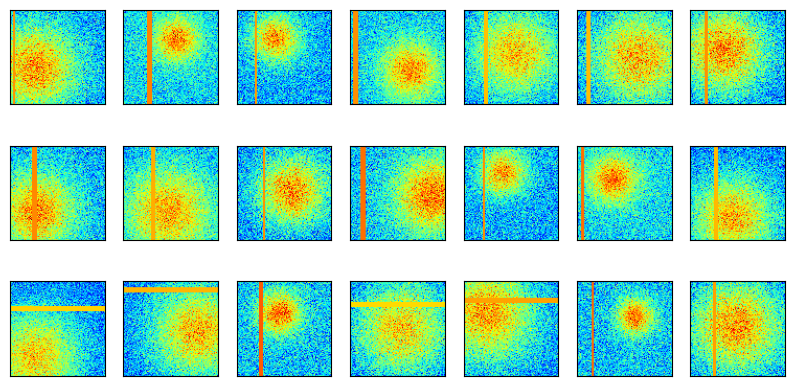

In [36]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  # ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.imshow(G,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show();

# Build the custom loss functions


In [53]:
# Function to create the custom loss functions - 1. MAE, 2. Conjunctive Loss Function, 3. Correlation Loss

class customLossfunc:
    def __init__(self):
      pass

    def validate(self, y_pred: Tensor, y_true: Tensor) -> None:
        assert y_pred.shape == y_true.shape, 'Shapes of y_pred and y_true do not match'

    def MAELoss(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
      self.validate(y_pred, y_true)
      return torch.mean(torch.abs(y_pred-y_true))

    def ConjunctiveLoss(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        self.validate(y_pred, y_true)
        mseloss = torch.mean( (y_pred-y_true)**2 )
        y_pred_mean = torch.abs(torch.mean(y_pred))
        return mseloss + y_pred_mean

    def CorrelationLoss(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
      self.validate(y_pred, y_true)

      y_pred = y_pred.float()
      y_true = y_true.float()

      y_pred_mean = torch.mean(y_pred)
      y_true_mean = torch.mean(y_true)

      # Center
      yP = y_pred - y_pred_mean
      yT = y_true - y_true_mean

      # population standard
      yP_std = torch.sqrt((yP ** 2).mean())
      yT_std = torch.sqrt((yT ** 2).mean())

      # denom
      eps = 1e-8
      denom = (yP_std * yT_std * (torch.numel(yT)-1)).clamp_min(eps)

      # Correlation
      corr = (yP * yT)/denom

      return - torch.mean(corr) # Return the mean of the correlation tensor

# Test the code

In [48]:
x = torch.randn(1,1,5,15)
y = torch.randn(1,1,5,15)

lossfun = customLossfunc()

print(f'MAE Loss: {lossfun.MAELoss(x,y)}')
print(f'Conjunctive Loss: {lossfun.ConjunctiveLoss(x,y)}')
print(f'Correlation Loss: {lossfun.CorrelationLoss(x,y)}')

MAE Loss: 1.077926516532898
Conjunctive Loss: 1.8034765720367432
Correlation Loss: tensor([[[[ 0.0047, -0.0104, -0.0414,  0.0092, -0.0008,  0.0107,  0.0013,
           -0.0265,  0.0117,  0.0076, -0.0107,  0.0116,  0.0014, -0.0010,
           -0.0072],
          [ 0.0004, -0.0099,  0.0029, -0.0022, -0.0027, -0.0317, -0.0103,
           -0.0011,  0.0056, -0.0053, -0.0081,  0.0030, -0.0045,  0.0065,
           -0.0008],
          [ 0.0013,  0.0036, -0.0015,  0.0162,  0.0108,  0.0020,  0.0001,
           -0.0013, -0.0136,  0.0021, -0.0067, -0.0416,  0.0062,  0.0030,
           -0.0022],
          [ 0.0075,  0.0043, -0.0043,  0.0003, -0.0075,  0.0082, -0.0024,
            0.0252, -0.0018,  0.0028,  0.0052,  0.0011,  0.0090,  0.0107,
           -0.0003],
          [-0.0002, -0.0274,  0.0014, -0.0520, -0.0032, -0.0169,  0.0114,
            0.0004,  0.0079,  0.0071,  0.0003,  0.0013,  0.0360,  0.0046,
           -0.0040]]]])


# Create the model

In [49]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = customLossfunc()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [50]:
# Test the model
net,lossfun,optimizer = makeTheNet()

X = images[0:1,:,:,:]

yHat = net(X)

loss = lossfun.CorrelationLoss(yHat, X)

print(loss.data)



tensor([[[[-4.9278e-05,  5.6232e-05, -3.2473e-05,  ...,  2.3123e-05,
            4.2113e-05, -1.5189e-05],
          [ 1.1391e-05,  1.1118e-04,  3.4194e-05,  ...,  7.3423e-05,
            5.0144e-05,  1.6957e-05],
          [-1.0114e-04, -1.6133e-05,  1.3339e-04,  ..., -3.4609e-05,
           -1.2839e-06,  1.3370e-06],
          ...,
          [-1.2383e-04, -9.9748e-06,  1.8702e-04,  ..., -7.0547e-06,
           -1.6624e-08,  1.5731e-05],
          [ 5.1692e-06,  2.6967e-05,  7.9576e-05,  ...,  4.2332e-05,
           -2.9251e-05, -2.9511e-05],
          [-9.0955e-05, -1.4923e-05, -2.1240e-04,  ..., -1.0465e-04,
            1.3180e-04, -1.0409e-05]]]])


# Train the model

In [51]:
def trainModel(numepochs,lossfunc):

  # train the image in batches of batch_size
  batch_size = 32

  epochloss = np.zeros(numepochs)

  lossfun = getattr(customLossfunc(), lossfunc)
  net, _, optimizer = makeTheNet()

  for epochi in range(numepochs):

    imgidx = np.random.choice(nGauss, size=batch_size, replace=False)
    X = images[imgidx,:,:,:]

    # forward pass and calculate loss
    yHat = net(X)
    loss = lossfun(yHat, X)

    epochloss[epochi] = loss.item()

    # back-propagatin
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return net, epochloss

# Run the model

In [54]:
lossfuncs = ['MAELoss','ConjunctiveLoss','CorrelationLoss']
numepochs = 500
losses_func = np.zeros((len(lossfuncs),numepochs))

for lossfunc in lossfuncs:
  losses = trainModel(numepochs, lossfunc)[1]
  losses_func[lossfuncs.index(lossfunc),:] = losses

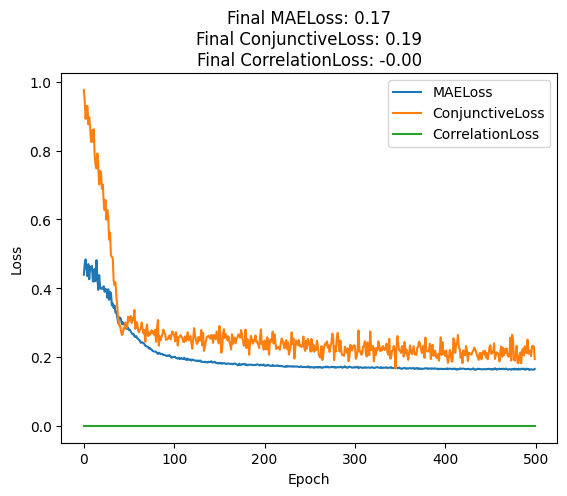

In [55]:
for lossi, lossfunc in enumerate(lossfuncs):
  plt.plot(losses_func[lossi,:], label=lossfunc)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Create a list of final loss values for the title with newline characters
final_losses_titles = [f'Final {lossfunc}: {losses_func[lossi,-1]:.2f}' for lossi, lossfunc in enumerate(lossfuncs)]
plt.title('\n'.join(final_losses_titles)) # Join with newline characters

plt.show();

In [62]:
# train the model with CorrelationLosses
net, _ = trainModel(500,'ConjunctiveLoss')

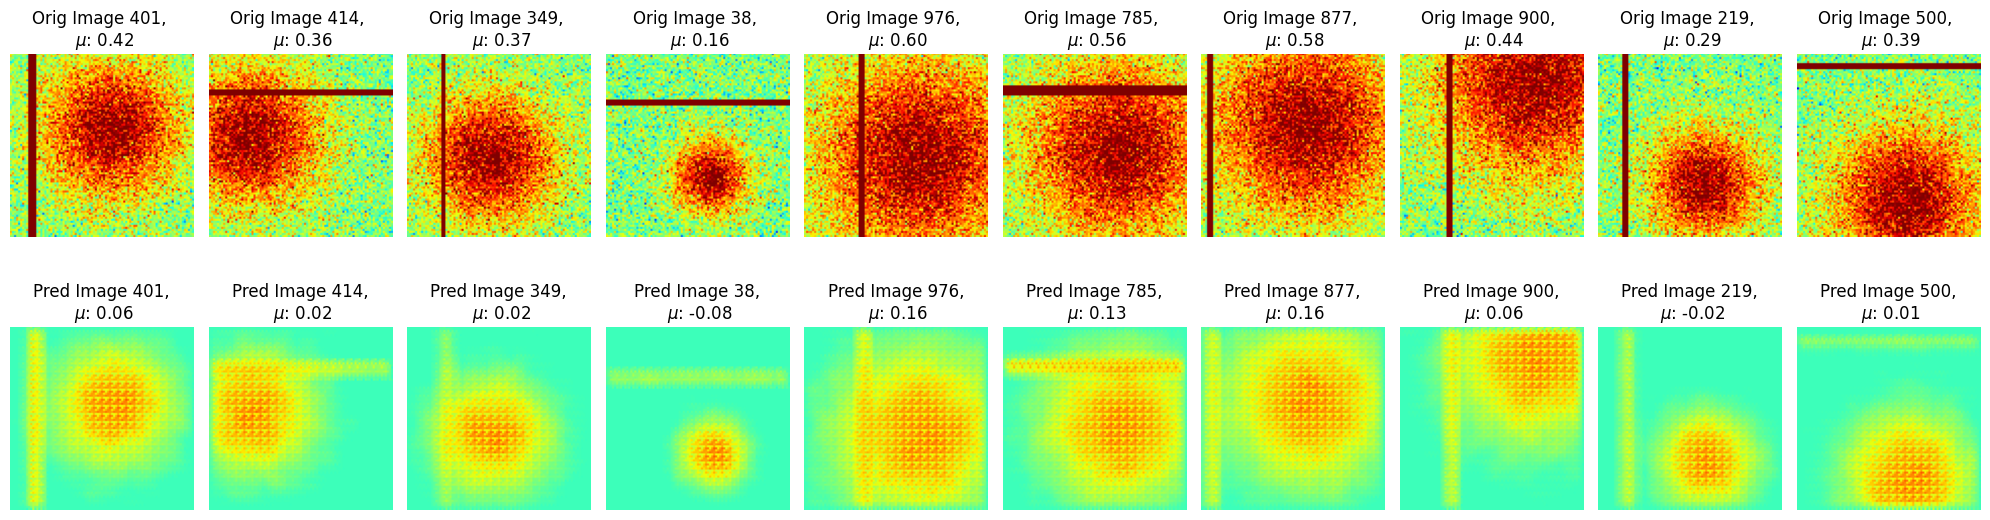

In [63]:
# visualize some images

images2test = 10
img_idx = np.random.choice(nGauss,size=images2test,replace=False)
X = images[img_idx,:,:,:]

yHat = net(X)

fig,axs = plt.subplots(2,images2test,figsize=(20,6))

for i in range(images2test):

  image_original = torch.squeeze( X[i,0,:,:] ).detach()
  image_pred = torch.squeeze( yHat[i,0,:,:] ).detach()

  # vmin, vmax = image_pred.min().item(), image_pred.max().item()
  vmin, vmax = -1, 1

  axs[0,i].imshow(image_original,vmin=vmin,vmax=vmax,cmap='jet')
  # axs[0,i].imshow(image_original,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title(f'Orig Image {img_idx[i]}, \n $\\mu$: {image_original.mean().item():.2f}')

  axs[1,i].imshow(image_pred,vmin=vmin,vmax=vmax,cmap='jet')
  # axs[1,i].imshow(image_pred,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title(f'Pred Image {img_idx[i]},\n $\\mu$: {image_pred.mean().item():.2f}')

plt.tight_layout()
plt.show();